<a href="https://colab.research.google.com/github/HK-TO/GANs/blob/main/InfoGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

以下のサイトを参照した.  
https://qiita.com/keiji_dl/items/45a5775a361151f9189d

In [1]:
import torch
from torch import nn

Define the discriminator and generator for MNIST datasets.

In [2]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 1)
        self.activation = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)

        return nn.Sigmoid()(x)

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(128, 1024)
        self.fc2 = nn.Linear(1024, 2048)
        self.fc3 = nn.Linear(2048, 784)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        x = x.view(-1, 1, 28, 28)
        return nn.Tanh()(x)

In [ ]:
class Auxiliary(nn.Moduel):
    def __init__(self):
        super(Auxiliary, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 10)
        self.activation = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return nn.Tanh()(x)

In [4]:
import time
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# set up the gpu device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# hyperparameter
epochs = 30
lr = 2e-4
batch_size = 64
loss = nn.BCELoss()

# Model
generator = Generator().to(device)
discriminator = Discriminator().to(device)

generator_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Define transform
transform = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize((0.5, ), (0.5, ))])

# Define data loader
train_set = datasets.MNIST('mnist/', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 164665412.12it/s]


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 7489532.20it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 48645907.63it/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 23872843.07it/s]


Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



In [6]:
# Learning process
for epoch in range(epochs):
    for idx, (imgs, _) in enumerate(train_loader):
        idx += 1

        # Train discriminator
        real_inputs = imgs.to(device)
        real_outputs = discriminator(real_inputs)
        real_label = torch.ones((real_inputs.shape[0], 1), device=device)

        noise = (torch.rand((real_inputs.shape[0], 128), device=device) - 0.5) / 0.5
        fake_inputs = generator(noise)
        fake_outputs = discriminator(fake_inputs)
        fake_label = torch.zeros((fake_inputs.shape[0], 1), device=device)

        outputs = torch.cat([real_outputs, fake_outputs], dim=0)
        labels = torch.cat([real_label, fake_label], dim=0)

        discriminator_loss = loss(outputs, labels)
        discriminator_optimizer.zero_grad()
        discriminator_loss.backward()
        discriminator_optimizer.step()

        # Train generator
        noise = (torch.rand((real_inputs.shape[0], 128), device=device) - 0.5) / 0.5
        fake_inputs = generator(noise)
        fake_outputs = discriminator(fake_inputs)
        fake_targets = torch.ones((fake_inputs.shape[0], 1), device=device)

        generator_loss = loss(fake_outputs, fake_targets)
        generator_optimizer.zero_grad()
        generator_loss.backward()
        generator_optimizer.step()

        if idx % 100 == 0 or idx == len(train_loader):
            print('Epoch {} Iteration {}: discriminator loss {:.3f} generator loss {:.3f}'.format(epoch, idx, discriminator_loss.item(), generator_loss.item()))

    torch.save(generator, 'Generator_{}'.format(epoch))
    print('Model saved.')

Epoch 0 Iteration 100: discriminator loss 0.597 generator loss 1.070
Epoch 0 Iteration 200: discriminator loss 0.678 generator loss 0.755
Epoch 0 Iteration 300: discriminator loss 0.694 generator loss 0.741
Epoch 0 Iteration 400: discriminator loss 0.638 generator loss 0.807
Epoch 0 Iteration 500: discriminator loss 0.569 generator loss 0.865
Epoch 0 Iteration 600: discriminator loss 0.514 generator loss 0.945
Epoch 0 Iteration 700: discriminator loss 0.543 generator loss 0.876
Epoch 0 Iteration 800: discriminator loss 0.484 generator loss 1.041
Epoch 0 Iteration 900: discriminator loss 0.483 generator loss 1.010
Epoch 0 Iteration 938: discriminator loss 0.478 generator loss 1.127
Model saved.
Epoch 1 Iteration 100: discriminator loss 0.473 generator loss 1.199
Epoch 1 Iteration 200: discriminator loss 0.455 generator loss 1.237
Epoch 1 Iteration 300: discriminator loss 0.465 generator loss 1.285
Epoch 1 Iteration 400: discriminator loss 0.506 generator loss 1.666
Epoch 1 Iteration 500

Generate images from trained model.

real


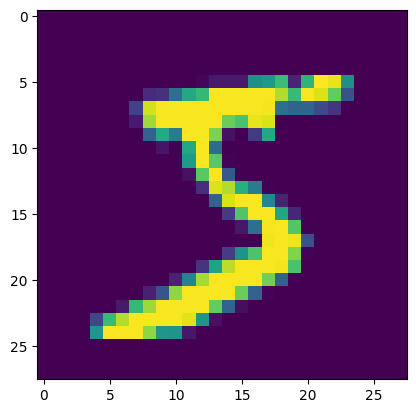

fake


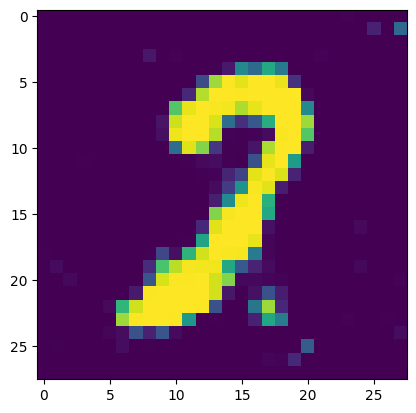

In [8]:
input = train_set
for i in input:
    print('real')
    plt.imshow(i[0][0].reshape(28, 28))
    plt.show()
    real_inputs = i[0][0]
    noise = (torch.rand(real_inputs.shape[0], 128)-0.5)/0.5
    noise = noise.to(device)
    fake_inputs = generator(noise)
    print("fake")
    plt.imshow(fake_inputs[0][0].cpu().detach().numpy().reshape(28,28))
    plt.show()
    break